Optimisation de l'entrainement pour `focus` 
This is the same function as used in `10_Transfer_learning_what_networks.ipynb`
> ... TODO ... # TODO test without circular padding, with Adam, with no warmstart 

    model = torchvision.models.resnet18(weights=None)

# optimize meta-parameters

In [1]:
# print_gpu_memory()

# print(path_save)
# %ls -l {path}*

# %rm {path} + '.sqlite3'  # FORCING RECOMPUTE

In [2]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
scan_dicts= {'delta2' : [0., 0.001]  }
label_dicts= { 'lr' : 'lr',  'delta2' : '1 - beta2', 'mutnemom' : 'mutnemom'}

In [ ]:
import retinoto_py as fovea
model_name = 'resnet101'
dataset = 'full'
dataset = 'bbox' # Select your root between : 'boxes', 'full'
batch_size = 64
opts_dict = dict(do_fovea=True, model_name=model_name, batch_size=batch_size,
                 num_epochs=5,
                 n_train_stop=256*batch_size, n_val_stop=64*batch_size, verbose=False)
args = fovea.Params(**opts_dict)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=1998, batch_size=64, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=5, n_train_stop=16384, n_val_stop=4096, lr=1e-05, delta1=0.1, delta2=0.0, weight_decay=0.01, label_smoothing=0.0, shuffle=True, verbose=True)

In [ ]:
model_filename = None # do not use resumed net
model_filename = args.data_cache / f'32_fovea_model_name={model_name}_dataset={dataset}_retrained.pth'

In [6]:
TRAIN_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'train'
train_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, TRAIN_DATA_DIR, n_stop=args.n_train_stop) #, in_memory=False)
train_loader = fovea.get_loader(args, train_dataset)
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
val_loader = fovea.get_loader(args, val_dataset)

Putting images in memory:   0%|          | 0/16384 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/4096 [00:00<?, ?it/s]

In [7]:
from torchvision import datasets
image_folder = datasets.ImageFolder(root=VAL_DATA_DIR, transform=None)

In [8]:
len(image_folder.imgs), len(image_folder)

(80477, 80477)

In [9]:
n_total = 20
import numpy as np
idxs = np.random.permutation(len(image_folder))[:n_total].astype(int)
idxs

array([56544, 44161, 24956, 80428, 69870, 67688, 58736, 27379, 29826,
       42777, 14806,  2543, 39674, 41826, 69999,  4248, 75622, 56030,
       30633, 22063])

In [10]:
%ls -l {model_filename}

-rw-r--r--  1 laurent  staff  178843891 26 nov.  15:25 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth


In [11]:
# subplotpars_scan = SubplotParams(left=0.125, right=.95, bottom=0.25, top=.975)
from dataclasses import asdict, field
# max_threshold = .999
for key in scan_dicts:
   
    print(50*'=')
    print('Scanning along', key, "=", label_dicts[key])
    print(50*'=')
    
    measure_columns = [key, 'accuracy']
    i_loc = 0
    for i_value, value in enumerate(scan_dicts[key]):
        filename = args.data_cache / f'34_optuna_{key}_{i_value}.json'
        if filename.is_file():
            df_scan = fovea.pd.read_json(filename)
        else:
            df_scan = fovea.pd.DataFrame([], columns=measure_columns)
            print('i_value', i_value + 1, ' /', len(scan_dicts[key]), key, '=', value)

            opt = fovea.Params(*opts_dict)

            new_dict = asdict(opt)
            new_dict[key] = value
            new_opt = fovea.Params(**new_dict)
            
            def objective(trial):
                    
                # # new_opt.batch_size = trial.suggest_int('batch_size', 16, 512, log=True, step=1)
                # # new_opt.rs_min = trial.suggest_float('rs_min', -1, 1.)
                # # new_opt.rs_max = trial.suggest_float('rs_max', -7, -4)
                # new_opt.mutnemom = trial.suggest_float('mutnemom', 0.01, 0.2, log=True)
                scale = 10
                new_opt.delta1 = trial.suggest_float('delta1', opt.delta1 / scale, opt.delta1 * scale, log=True)
                if new_opt.delta2>0: new_opt.delta2 = trial.suggest_float('delta2', 0.001, 0.9, log=True)

                scale = 100 
                # weight_decay = 0.005 if opt.weight_decay==0 else opt.weight_decay
                # new_opt.weight_decay = trial.suggest_float('weight_decay', weight_decay / scale, weight_decay * scale, log=True)
                # label_smoothing = 0.005 if opt.label_smoothing==0 else opt.label_smoothing
                # new_opt.label_smoothing = trial.suggest_float('label_smoothing', label_smoothing / scale, label_smoothing * scale, log=True)
                new_opt.lr = trial.suggest_float('lr', opt.lr / scale, opt.lr * scale, log=True)
                # new_opt.im_mean = trial.suggest_float('im_mean', opt.im_mean / scale, opt.im_mean * scale, log=True)
                # new_opt.im_std = trial.suggest_float('im_std', opt.im_std / scale, opt.im_std * scale, log=True)

                # get the architecture of the network
                model = fovea.load_model(args, model_path=model_filename)

                # train and get accuracy on the validation set
                _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)

                accuracy = df_train['acc_val'].mean()
                
                return accuracy
                
            # 3. Create a study object and optimize the objective function.
            sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
            opt_tuna= dict(storage=f"sqlite:///cached_data/34_optuna.sqlite3", 
                           sampler=sampler, direction='maximize', load_if_exists=True, study_name=f"{key} = {value}")
            study = optuna.create_study(**opt_tuna)
            print(f'Starting optimization for {key} = {value} with params: {new_opt} on {max(150-len(study.trials), 0)} trials / {len(study.trials)} ')
            study.optimize(objective, n_trials=max((150-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)

            print(50*'-.')
            print("Best params: ", study.best_params)
            print("Best value: ", study.best_value)
            print("Best Trial: ", study.best_trial)
            # print("Trials: ", study.trials)
            print(50*'-.')
            df_scan.loc[i_loc] = {key:value, 'accuracy':study.best_value}
            # print_gpu_memory()

            df_scan.to_json(filename, orient='index', indent=2)

        print(df_scan)
        print(50*'=')

Scanning along delta2 = 1 - beta2
i_value 1  / 2 delta2 = 0.0
Starting optimization for delta2 = 0.0 with params: Params(image_size='do_fovea', do_mask='model_name', do_fovea='batch_size', rs_min='num_epochs', rs_max='n_train_stop', padding_mode='n_val_stop', seed=1998, batch_size=64, num_workers=4, in_memory=True, model_name='resnet101', do_scratch=False, num_epochs=10, n_train_stop=32768, n_val_stop=4096, lr=1e-05, delta1=0.1, delta2=0.0, weight_decay=0.01, label_smoothing=0.0, shuffle=True, verbose=True) on 138 trials / 12 


/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


  0%|          | 0/138 [00:00<?, ?it/s]

loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 1/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=2/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 2/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=3/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 3/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=4/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 4/5:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=5/5:   0%|          | 0/256 [00:00<?, ?it/s]

Vat @Epoch 5/5:   0%|          | 0/64 [00:00<?, ?it/s]

Saving.../tmp/resnet.pth
loading .... cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained.pth
Starting learning...


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

epoch=1/5:   0%|          | 0/256 [00:00<?, ?it/s]

[W 2025-11-26 17:51:22,349] Trial 19 failed with parameters: {'weight_decay': 0.004751119866685026, 'label_smoothing': 0.05818915794065967, 'lr': 5.744550432005743e-07} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_8816/1618441448.py", line 48, in objective
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
                  ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/src/retinoto_py/retinoto_py.py", line 208, in train_model
    running_corrects += (predicted_labels == true_labels).sum().item()
                        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

KeyboardInterrupt: 

In [12]:
import optuna.visualization.matplotlib as vis

/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_8816/173483681.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_param_importances(study)
/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/optuna/visualization/matplotlib/_param_importances.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

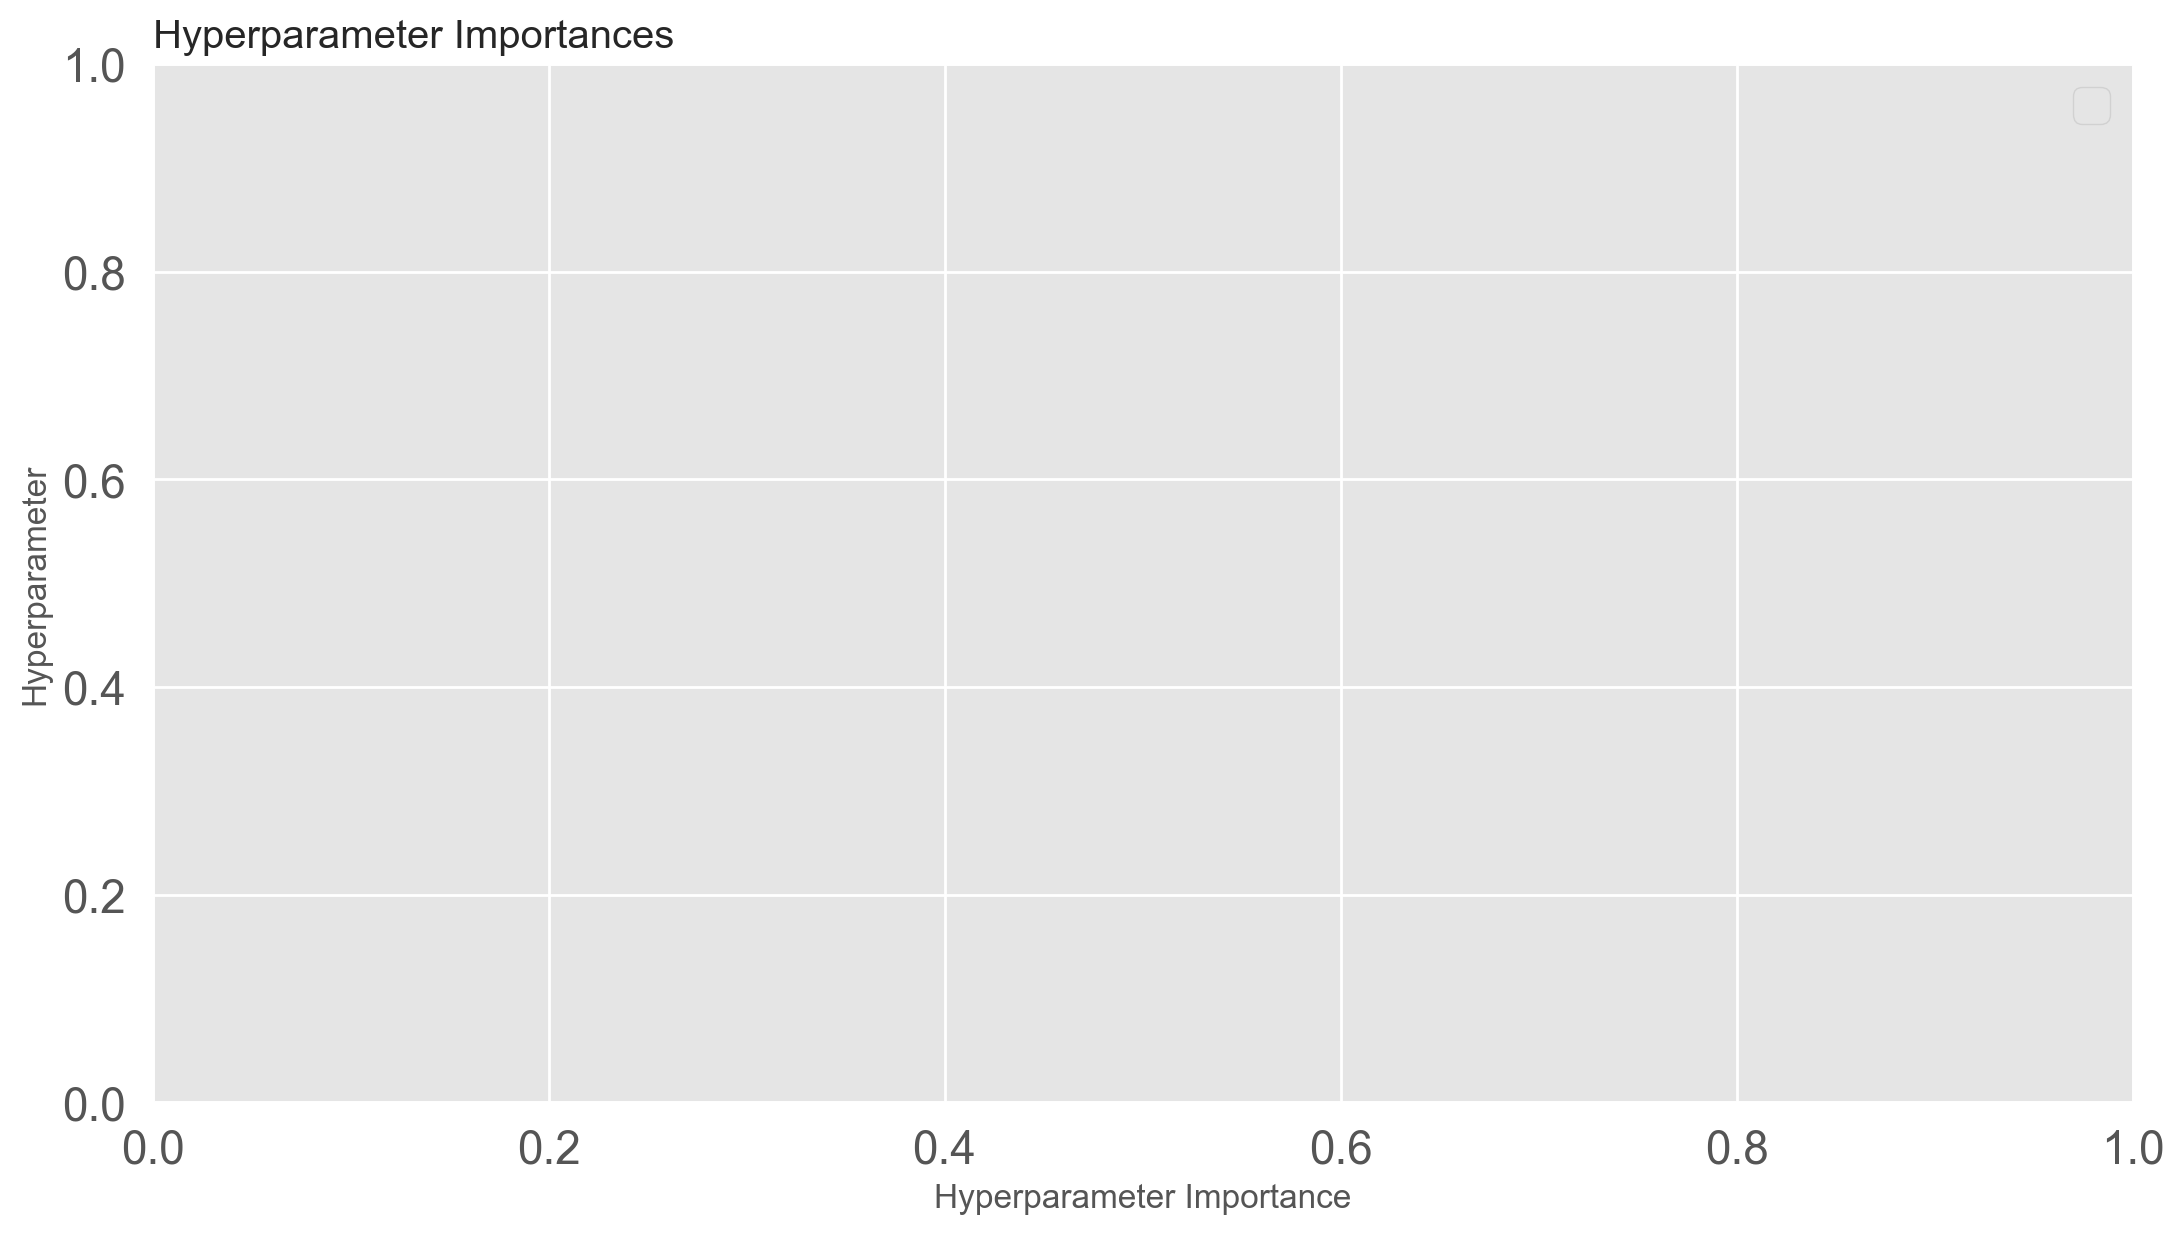

In [13]:
vis.plot_param_importances(study)

In [14]:
# df = study.trials_dataframe()   
params = sorted({k for t in study.trials for k in t.params})
params

['label_smoothing', 'lr', 'weight_decay']

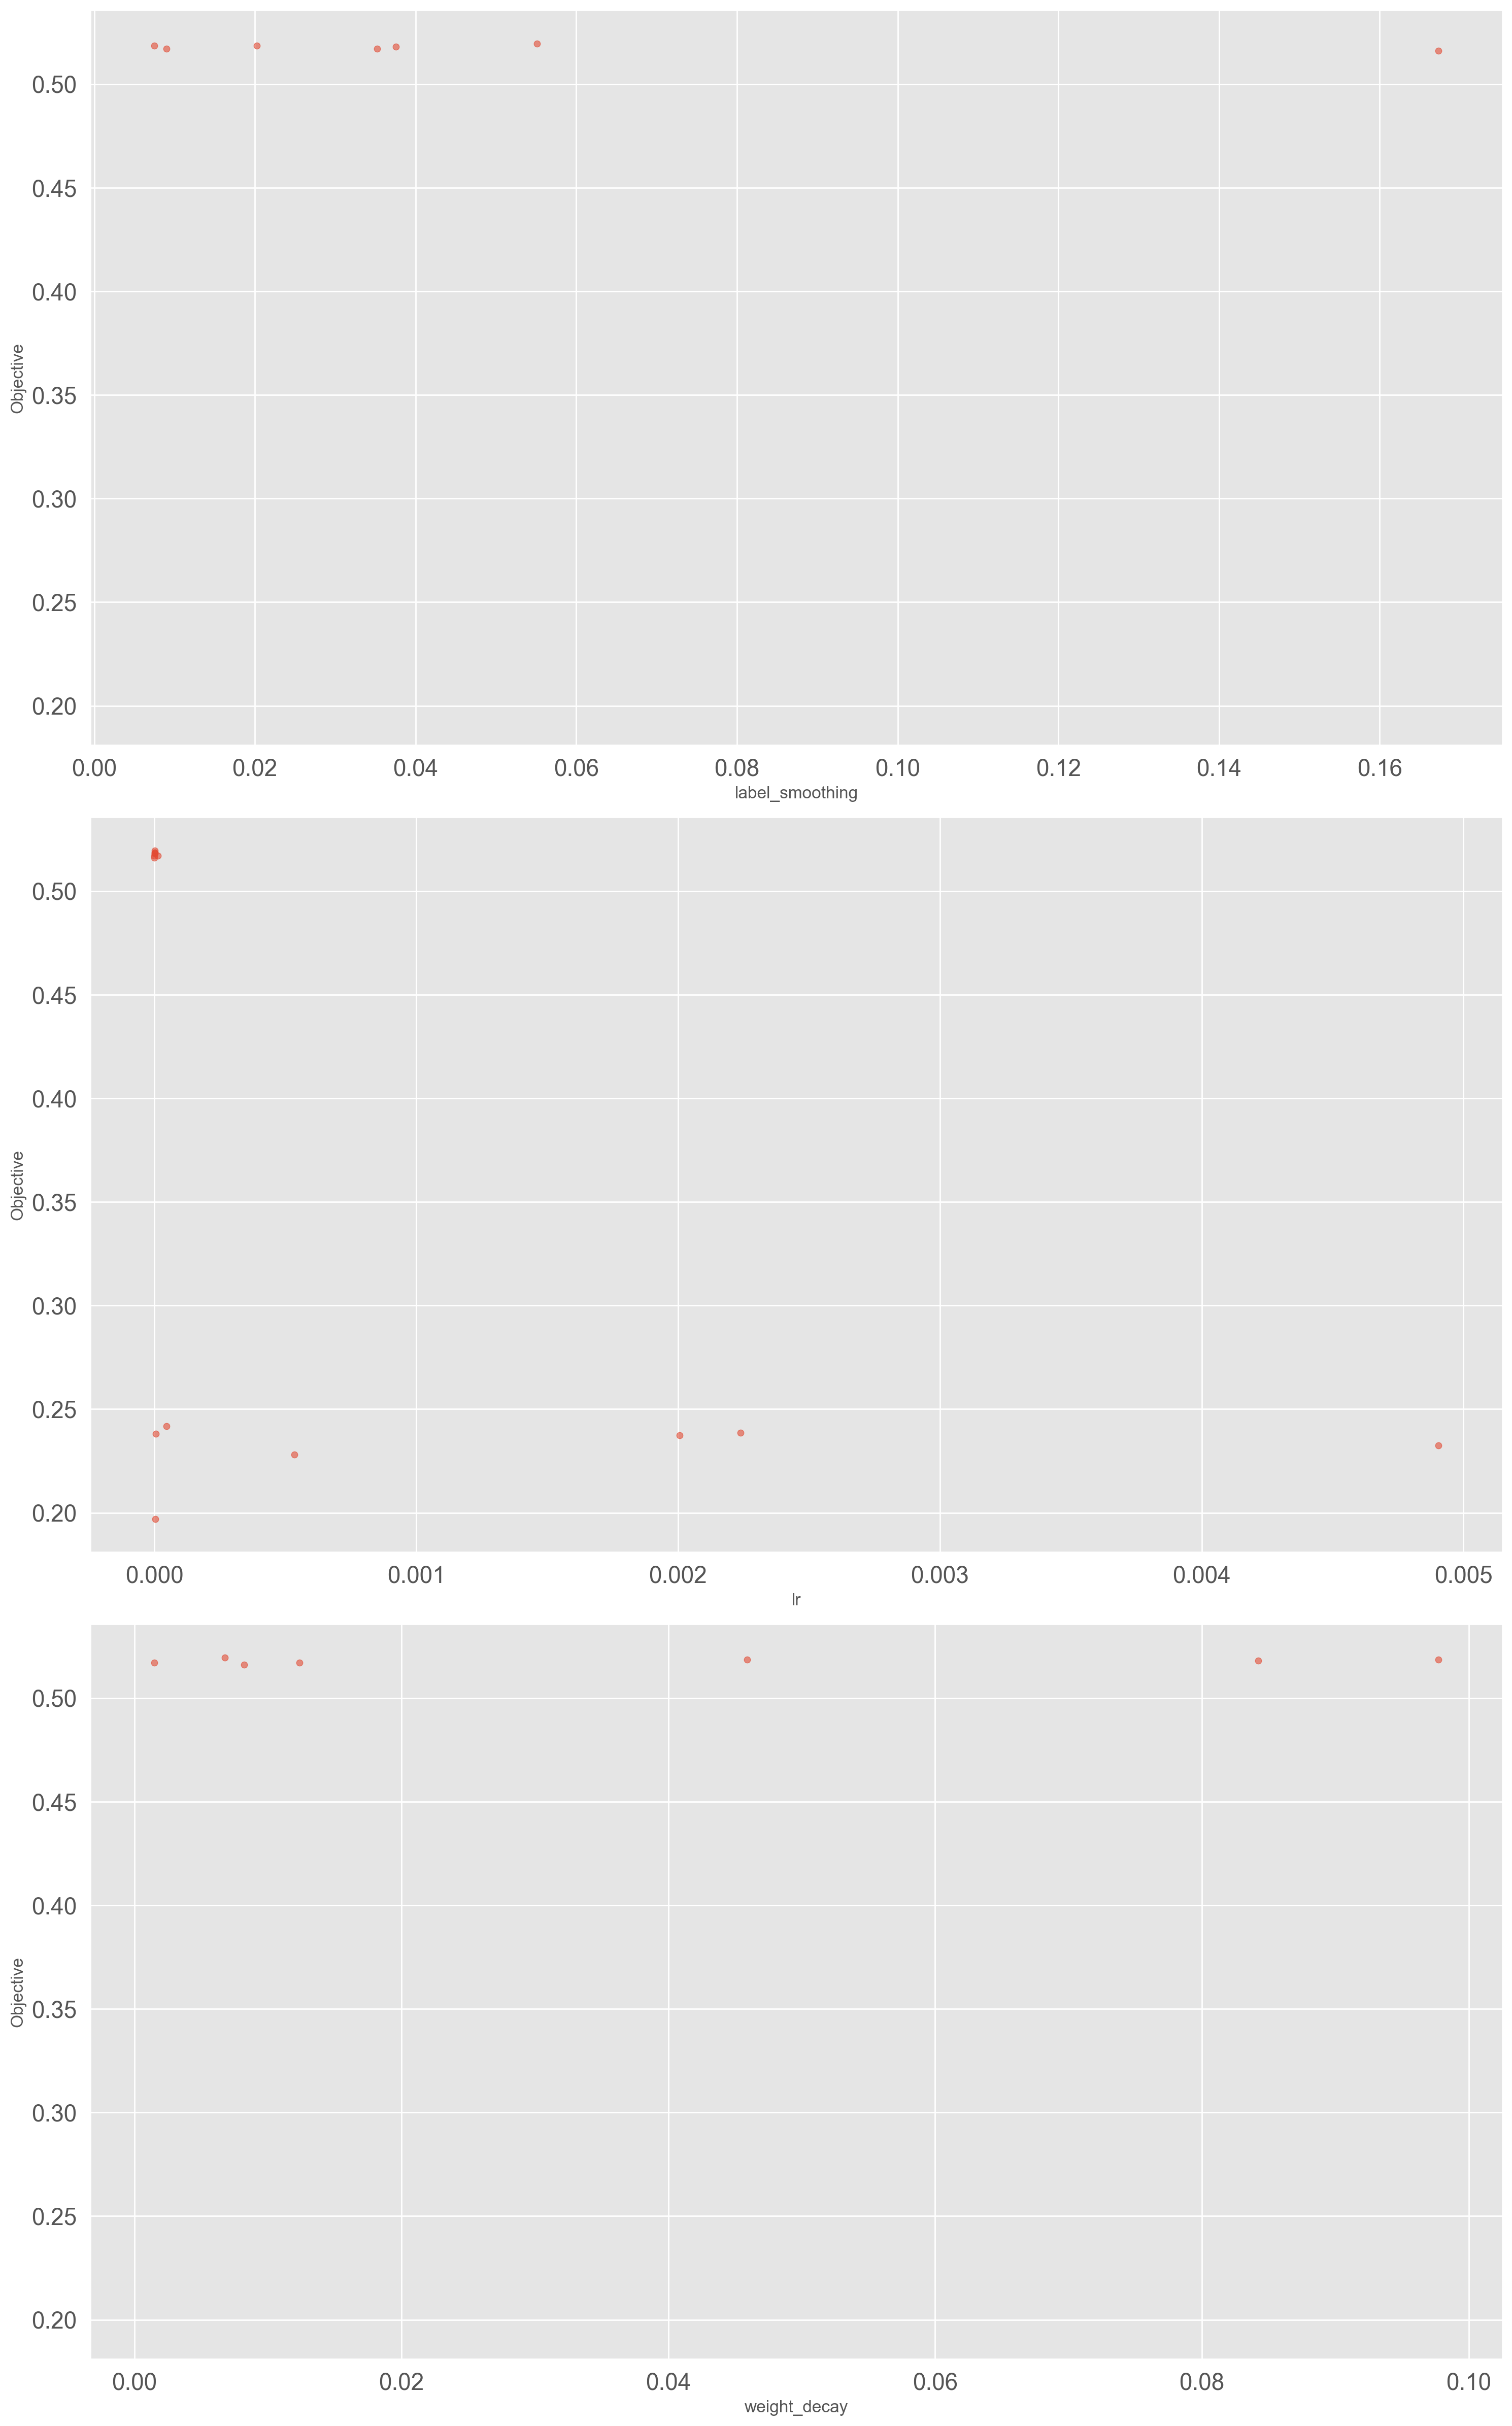

In [15]:

fig, axes = fovea.plt.subplots(len(params), 1, figsize=(15, 8*len(params)), sharey=True)

for ax, pname in zip(axes, params):
    xs = [t.params[pname] for t in study.trials if pname in t.params]
    ys = [t.value for t in study.trials if pname in t.params]
    ax.scatter(xs, ys, s=20, alpha=0.6)
    ax.set_xlabel(pname)
    ax.set_ylabel("Objective")

fovea.plt.tight_layout()


In [ ]:
# vis.plot_contour(study, params=["weight_quanta", "resample_rate"])
# vis.plot_contour(study, params=["num_particles", "chunk_size"])